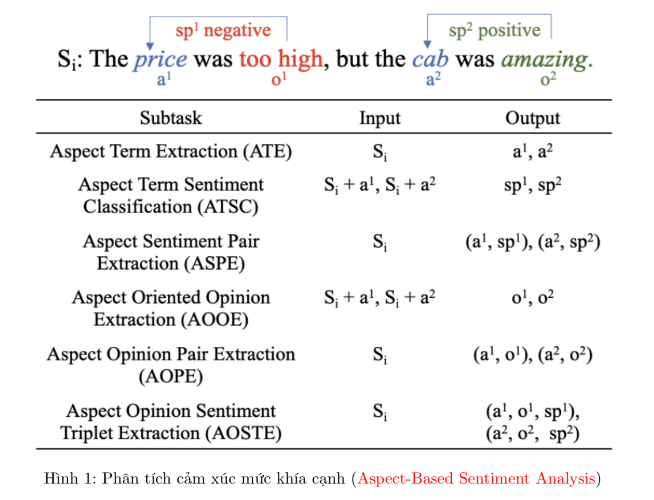

# **I. Aspect Term Extraction**

## Dataset

In [ ]:
!gdown 1d7JABk4jViI-USjLsWmhGkvzi8uQIL5C
!unzip ./data.zip

Downloading...
From: https://drive.google.com/uc?id=1d7JABk4jViI-USjLsWmhGkvzi8uQIL5C
To: /content/data.zip
100% 151k/151k [00:00<00:00, 3.07MB/s]
Archive:  ./data.zip
   creating: data/
  inflating: __MACOSX/._data         
  inflating: data/restaurants_train.csv  
  inflating: __MACOSX/data/._restaurants_train.csv  
  inflating: data/restaurants_test.csv  
  inflating: __MACOSX/data/._restaurants_test.csv  


In [ ]:
import pandas as pd

train_df = pd.read_csv('./data/restaurants_train.csv')
test_df = pd.read_csv('./data/restaurants_test.csv')

In [ ]:
train_df.head()

,Tokens,Tags,Polarities
0,"['But', 'the', 'staff', 'was', 'so', 'horrible...","[0, 0, 1, 0, 0, 0, 0, 0, 0]","[-1, -1, 0, -1, -1, -1, -1, -1, -1]"
1,"['To', 'be', 'completely', 'fair', 'the', 'onl...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2..."
2,"['The', 'food', 'is', 'uniformly', 'exceptiona...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[-1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1..."
3,"['The', 'food', 'is', 'uniformly', 'exceptiona...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, -1..."
4,"['The', 'food', 'is', 'uniformly', 'exceptiona...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."


In [ ]:
train_df.iloc[0]

Tokens        ['But', 'the', 'staff', 'was', 'so', 'horrible...
Tags                                [0, 0, 1, 0, 0, 0, 0, 0, 0]
Polarities                  [-1, -1, 0, -1, -1, -1, -1, -1, -1]
Name: 0, dtype: object

In [ ]:
from transformers import BertTokenizer

model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
tokenizer.all_special_tokens

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']

In [ ]:
tokenizer.cls_token_id

101

In [ ]:
tokenizer.sep_token_id

102

In [ ]:
# word-level: Breaks the text into individual words based on spaces
# --> "I am Bard, a large language model." will be broken into: ["I", "is", "Bard", "a", "model", "shape", "language", "language", "large", "."]

# Sub-word level: Breaks the text into units smaller than words, which can be syllables, prefixes, suffixes, or other parts of words.
# --> For example, "I am Bard, a large language model." will be broken into: ["I", "is", "Bar", "d", "model", "shape", "language", "language", "large", "."]

In [ ]:
# Build dataset
import torch
from torch.utils.data import Dataset

class ABSADataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        tokens, tags, pols = self.df.iloc[idx, :3].values

        tokens = tokens.replace("'", "").strip('[]').split(', ')
        tags = tags.strip('[]').split(', ')
        pols = pols.strip('[]').split(', ')

        bert_tokens = []
        bert_tags = []
        bert_pols = []
        for i in range(len(tokens)): # duyệt qua từng token, tokenize theo sub-word
            t = self.tokenizer.tokenize(tokens[i])
            bert_tokens += t
            bert_tags += [int(tags[i])]*len(t)
            bert_pols += [int(pols[i])]*len(t)

        bert_ids = self.tokenizer.convert_tokens_to_ids(bert_tokens)

        ids_tensor = torch.tensor(bert_ids)
        tags_tensor = torch.tensor(bert_tags)
        pols_tensor = torch.tensor(bert_pols)

        return bert_tokens, ids_tensor, tags_tensor, pols_tensor

In [ ]:
train_ds = ABSADataset(train_df, tokenizer)
test_ds = ABSADataset(test_df, tokenizer)

In [ ]:
len(train_ds), len(test_ds)

(3602, 1119)

In [ ]:
next(iter(train_ds))

(['but', 'the', 'staff', 'was', 'so', 'horrible', 'to', 'us'],
 tensor([2021, 1996, 3095, 2001, 2061, 9202, 2000, 2149]),
 tensor([0, 0, 1, 0, 0, 0, 0, 0]),
 tensor([-1, -1,  0, -1, -1, -1, -1, -1]))

In [ ]:
# Dataloader
from torch.nn.utils.rnn import pad_sequence

def padding(samples):
    # lấy ra ids của từng sample
    ids_tensors = [s[1] for s in samples] # 26
    ids_tensors = pad_sequence(ids_tensors, batch_first=True) # 46

    tags_tensors = [s[2] for s in samples]
    tags_tensors = pad_sequence(tags_tensors, batch_first=True)

    pols_tensors = [s[3] for s in samples]
    pols_tensors = pad_sequence(pols_tensors, batch_first=True)

    masks_tensors = torch.zeros(ids_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(ids_tensors != 0, 1) # những vị trí ids_tensor != 0 thì fill = 1

    return ids_tensors, tags_tensors, pols_tensors, masks_tensors

In [ ]:
from torch.utils.data import DataLoader

batch_size = 32
train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, collate_fn=padding
)

test_loader = DataLoader(
    test_ds, batch_size=batch_size, shuffle=True, collate_fn=padding
)

In [ ]:
next(iter(train_loader))

(tensor([[ 1996,  3095,  3084,  2017,  2514,  2012,  2188,  1996,  2833,  2003,
           2307,  1998,  1996,  7224,  2003,  6919,     0,     0,     0,     0],
         [ 2130,  2295,  1996,  4825,  2001,  8966,  2057,  2020,  8901, 13364,
           1998,  2130,  2356,  2005,  1037,  2795,  8721,  2007,  2053,  3471]]),
 tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]]),
 tensor([[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  2, -1,  0,  0,
           0,  0],
         [-1, -1, -1, -1, -1, -1, -1, -1, -1,  2, -1, -1, -1, -1, -1, -1, -1, -1,
          -1, -1]]),
 tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]))

## Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
from transformers import BertModel

class ABTEBert(torch.nn.Module):
    def __init__(self, model_name):
        super(ABTEBert, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.linear = torch.nn.Linear(self.bert.config.hidden_size, 2) # 768
        self.loss_fn = torch.nn.CrossEntropyLoss()

    def forward(self, ids_tensors, masks_tensors, tags_tensors):
        # ids_tensors.shape: [32, 43]

        bert_outputs = self.bert(input_ids=ids_tensors,
                                attention_mask=masks_tensors,
                                return_dict=False) # return_dict (bool, optional) — Whether or not to return a ModelOutput instead of a plain tuple. Mô hình sẽ trả về một tuple đơn giản chứa tất cả các đầu ra của mô hình

        # tức là 1 cái trả về tuple chứa các đầu ra còn True thì vẫn trả về như thế nhưng là 1 object của modeloutput
        # https://stackoverflow.com/questions/71755090/for-what-is-used-parameter-return-dict-in-bertmodel
        # Thứ tự của các đầu ra trong tuple sẽ giống với thứ tự của các thuộc tính trong đối tượng ModelOutput.

        bert_outputs = bert_outputs[0] # [32, 43, 768]

        linear_outputs = self.linear(bert_outputs) # [32, 43, 2]

        if tags_tensors is not None:
            tags_tensors = tags_tensors.view(-1) # [32, 43] --> [1376]
            linear_outputs_ = linear_outputs.view(-1,3) # [32, 43, 2] --> [1376, 2]

            loss = self.loss_fn(linear_outputs_, tags_tensors) # []
            return loss, linear_outputs
        else:
            return linear_outputs

In [ ]:
model = ABTEBert(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
inputs = next(iter(train_loader))
prediction = model(inputs[0],
                   inputs[2],
                   inputs[1],)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
model.to(device)

ABTEBert(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

In [ ]:
import time
import numpy  as np
from sklearn.metrics import classification_report

def train_epoch(model, optimizer, train_loader, device):
    losses = []
    for batch in (train_loader):
        ids_tensors, tags_tensors, _, masks_tensors = batch
        ids_tensors = ids_tensors.to(device)
        tags_tensors = tags_tensors.to(device)
        masks_tensors = masks_tensors.to(device)

        loss, _ = model(
            ids_tensors=ids_tensors,
            masks_tensors=masks_tensors,
            tags_tensors=tags_tensors
        )
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return sum(losses)/len(losses)

def evaluate_epoch(model, valid_loader, device):
    losses = []

    preds, labels = [], []
    with torch.no_grad():
        for batch in (valid_loader):
            ids_tensors, tags_tensors, _, masks_tensors = batch
            ids_tensors = ids_tensors.to(device)
            tags_tensors = tags_tensors.to(device)
            masks_tensors = masks_tensors.to(device)

            loss, outputs = model(
                ids_tensors=ids_tensors,
                masks_tensors=masks_tensors,
                tags_tensors=tags_tensors
            ) # bs, seq, classes
            losses.append(loss.item())

            _, p = torch.max(outputs, dim=2) # bs, seq
            preds += list([int(j) for i in p for j in i ])
            labels += list([int(j) for i in tags_tensors for j in i ])

    acc = np.mean(np.array(preds) == np.array(labels))
    return sum(losses)/len(losses), acc

def train(model, model_name, save_model, optimizer, train_loader, valid_loader, num_epochs, device):
    train_losses = []
    eval_accs, eval_losses = [], []
    best_loss_eval = 100
    times = []
    for epoch in range(1, num_epochs+1):
        epoch_start_time = time.time()
        # Training
        train_loss = train_epoch(model, optimizer, train_loader, device)
        train_losses.append(train_loss)

        # Evaluation
        eval_loss, eval_acc = evaluate_epoch(model, valid_loader, device)
        eval_accs.append(eval_acc)
        eval_losses.append(eval_loss)

        # Save best model
        if eval_loss < best_loss_eval:
            torch.save(model.state_dict(), save_model + f'/{model_name}.pt')

        times.append(time.time() - epoch_start_time)
        # Print loss, acc end epoch
        print("-" * 59)
        print(
            "| End of epoch {:3d} | Time: {:5.2f}s | Train Loss {:8.3f} "
            "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
                epoch, time.time() - epoch_start_time, train_loss, eval_acc, eval_loss
            )
        )
        print("-" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + f'/{model_name}.pt'))
    model.eval()
    metrics = {
        'train_loss': train_losses,
        'valid_accuracy': eval_accs,
        'valid_loss': eval_losses,
        'time': times
    }
    return model, metrics

In [ ]:
np.mean([True, True, False, True])

0.75

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

In [ ]:
loss = train_epoch(model, optimizer, train_loader, device)
loss

0.15587166914370207

In [ ]:
loss, acc = evaluate_epoch(model, test_loader, device)
loss, acc

(0.22080511791365487, 0.9155404089581305)

## Training

In [ ]:
!mkdir "./model"

In [ ]:
save_model = "./model"
model = ABTEBert(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
num_epochs = 5
best_model, metrics = train(
    model, model_name, save_model, optimizer, train_loader, test_loader, num_epochs, device
)

-----------------------------------------------------------
| End of epoch   1 | Time: 42.51s | Train Loss    0.268 | Valid Accuracy    0.911 | Valid Loss    0.232 
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   2 | Time: 37.59s | Train Loss    0.157 | Valid Accuracy    0.911 | Valid Loss    0.224 
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   3 | Time: 36.47s | Train Loss    0.102 | Valid Accuracy    0.915 | Valid Loss    0.241 
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   4 | Time: 38.12s | Train Loss    0.056 | Valid Accuracy    0.917 | Valid Loss    0.295 
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   5 | Time: 37.34s | Trai

## Prediction

In [ ]:
def predict(best_model, sentence, device):
    word_pieces = list(tokenizer.tokenize(sentence))
    input_ids = tokenizer.convert_tokens_to_ids(word_pieces)
    input_tensor = torch.tensor([input_ids]).to(device)

    with torch.no_grad():
        outputs = model(input_tensor, None, None)
        _, predictions = torch.max(outputs, dim=2)

    predictions = predictions[0].tolist()
    return word_pieces, predictions, outputs

In [ ]:
sentence = " ".join(test_df.iloc[0]["Tokens"].replace("'", "").strip("][").split(', '))
predict(best_model, sentence, device)

# **Phần II. Aspect Term Sentiment Classification**

## Dataset

In [ ]:
import pandas as pd

train_df = pd.read_csv('./data/restaurants_train.csv')
test_df = pd.read_csv('./data/restaurants_test.csv')

In [ ]:
train_df.iloc[0]

Tokens        ['But', 'the', 'staff', 'was', 'so', 'horrible...
Tags                                [0, 0, 1, 0, 0, 0, 0, 0, 0]
Polarities                  [-1, -1, 0, -1, -1, -1, -1, -1, -1]
Name: 0, dtype: object

In [ ]:
from transformers import BertTokenizer

model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
tokenizer.all_special_tokens

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']

In [ ]:
tokenizer.cls_token_id

101

In [ ]:
tokenizer.sep_token_id

102

In [ ]:
import torch
from torch.utils.data import Dataset

class ABSADataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        tokens, tags, pols = self.df.iloc[idx, :3].values

        tokens = tokens.replace("'", "").strip("][").split(', ')
        tags = tags.strip('][').split(', ')
        pols = pols.strip('][').split(', ')
        # ['The', 'food', 'is', 'uniformly', 'exceptional', 'with', 'a', 'very', ...]
        # ['0',     '1',  '0',      '0',          '0',       '0',   '0',  '0', ...]
        # ['-1',    '2',  '-1',    '-1',         '-1',      '-1',  '-1',  '-1', ...]

        bert_tokens = []
        bert_att = []
        pols_label = 0
        for i in range(len(tokens)): # duyệt qua từng token
            t = self.tokenizer.tokenize(tokens[i])
            bert_tokens += t
            if int(pols[i]) != -1: # nếu từ đó có sắc thái nghĩa
                bert_att += t
                pols_label = int(pols[i])

        #  input task predict next sentence của BERT yêu cầu segment (0 cho câu thứ nhất, 1 cho câu thứ 2)
        segment_tensor = [0] + [0]*len(bert_tokens) + [0] + [1]*len(bert_att)
        # định dạng cho next sentence objective của BERT là 'cls' + sentence1 + 'sep' + sentence2
        bert_tokens = ['[CLS]'] + bert_tokens + ['[SEP]'] + bert_att

        bert_ids = self.tokenizer.convert_tokens_to_ids(bert_tokens)

        ids_tensor = torch.tensor(bert_ids)
        pols_tensor = torch.tensor(pols_label)
        segment_tensor = torch.tensor(segment_tensor)

        return bert_tokens, ids_tensor, segment_tensor, pols_tensor

In [ ]:
train_ds = ABSADataset(train_df, tokenizer)
test_ds = ABSADataset(test_df, tokenizer)

In [ ]:
next(iter(train_ds))

(['[CLS]',
  'but',
  'the',
  'staff',
  'was',
  'so',
  'horrible',
  'to',
  'us',
  '[SEP]',
  'staff'],
 tensor([ 101, 2021, 1996, 3095, 2001, 2061, 9202, 2000, 2149,  102, 3095]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]),
 tensor(0))

In [ ]:
from torch.nn.utils.rnn import pad_sequence

def padding(samples):
    ids_tensors = [s[1] for s in samples]
    ids_tensors = pad_sequence(ids_tensors, batch_first=True)

    segments_tensors = [s[2] for s in samples]
    segments_tensors = pad_sequence(segments_tensors, batch_first=True)

    label_ids = torch.stack([s[3] for s in samples])

    masks_tensors = torch.zeros(ids_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(ids_tensors != 0, 1)

    return ids_tensors, segments_tensors, masks_tensors, label_ids

In [ ]:
from torch.utils.data import DataLoader

batch_size = 32
train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, collate_fn=padding
)
test_loader = DataLoader(
    test_ds, batch_size=batch_size, shuffle=True, collate_fn=padding
)

## Model

In [ ]:
from transformers import BertModel

class ABSABert(torch.nn.Module):
    def __init__(self, model_name):
        super(ABSABert, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.linear = torch.nn.Linear(self.bert.config.hidden_size, 3)
        self.loss_fn = torch.nn.CrossEntropyLoss()

    def forward(self, ids_tensors, masks_tensors, segments_tensors, lable_tensors):
        out_dict = self.bert(
            input_ids=ids_tensors,
            attention_mask=masks_tensors,
            token_type_ids=segments_tensors
        )

        linear_outputs = self.linear(out_dict['pooler_output'])
        # https://huggingface.co/docs/transformers/v4.20.1/en/main_classes/output#transformers.utils.ModelOutput

        if lable_tensors is not None:
            loss = self.loss_fn(linear_outputs, lable_tensors)
            return loss, linear_outputs
        else:
            return linear_outputs

In [ ]:
model = ABSABert(model_name)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
model.to(device)

ABSABert(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

In [ ]:
import time
import numpy as np

def train_epoch(model, optimizer, train_loader, device):
    losses = []
    for batch in (train_loader):
        ids_tensors, segments_tensors, masks_tensors, label_ids = batch
        ids_tensors = ids_tensors.to(device)
        segments_tensors = segments_tensors.to(device)
        label_ids = label_ids.to(device)
        masks_tensors = masks_tensors.to(device)

        loss, _ = model(
            ids_tensors=ids_tensors,
            masks_tensors=masks_tensors,
            segments_tensors=segments_tensors,
            lable_tensors=label_ids
        )
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return sum(losses)/len(losses)

def evaluate_epoch(model, valid_loader, device):
    losses = []

    preds, labels = [], []
    with torch.no_grad():
        for batch in (valid_loader):
            ids_tensors, segments_tensors, masks_tensors, label_ids = batch
            ids_tensors = ids_tensors.to(device)
            segments_tensors = segments_tensors.to(device)
            masks_tensors = masks_tensors.to(device)
            label_ids = label_ids.to(device)

            loss, outputs = model(
                ids_tensors=ids_tensors,
                masks_tensors=masks_tensors,
                segments_tensors=segments_tensors,
                lable_tensors=label_ids
            )
            losses.append(loss.item())

            _, p = torch.max(outputs, dim=1)
            preds += list([int(i) for i in p])
            labels += list([int(i) for i in label_ids])

    acc = np.mean(np.array(preds) == np.array(labels))
    return sum(losses)/len(losses), acc

def train(model, model_name, save_model, optimizer, train_loader, valid_loader, num_epochs, device):
    train_losses = []
    eval_accs, eval_losses = [], []
    best_loss_eval = 100
    times = []
    for epoch in range(1, num_epochs+1):
        epoch_start_time = time.time()
        # Training
        train_loss = train_epoch(model, optimizer, train_loader, device)
        train_losses.append(train_loss)

        # Evaluation
        eval_loss, eval_acc = evaluate_epoch(model, valid_loader, device)
        eval_accs.append(eval_acc)
        eval_losses.append(eval_loss)

        # Save best model
        if eval_loss < best_loss_eval:
            torch.save(model.state_dict(), save_model + f'/{model_name}.pt')

        times.append(time.time() - epoch_start_time)
        # Print loss, acc end epoch
        print("-" * 59)
        print(
            "| End of epoch {:3d} | Time: {:5.2f}s | Train Loss {:8.3f} "
            "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
                epoch, time.time() - epoch_start_time, train_loss, eval_acc, eval_loss
            )
        )
        print("-" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + f'/{model_name}.pt'))
    model.eval()
    metrics = {
        'train_loss': train_losses,
        'valid_accuracy': eval_accs,
        'valid_loss': eval_losses,
        'time': times
    }
    return model, metrics

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

In [ ]:
loss = train_epoch(model, optimizer, train_loader, device)
loss

In [ ]:
loss, acc = evaluate_epoch(model, test_loader, device)
loss, acc

## Training

In [ ]:
!mkdir "./model"

In [ ]:
save_model = "./model"
model = ABSABert(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
num_epochs = 5
best_model, metrics = train(
    model, model_name, save_model, optimizer, train_loader, test_loader, num_epochs, device
)

-----------------------------------------------------------
| End of epoch   1 | Time: 46.77s | Train Loss    0.829 | Valid Accuracy    0.748 | Valid Loss    0.644 
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   2 | Time: 39.83s | Train Loss    0.539 | Valid Accuracy    0.801 | Valid Loss    0.507 
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   3 | Time: 39.13s | Train Loss    0.353 | Valid Accuracy    0.814 | Valid Loss    0.469 
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   4 | Time: 40.16s | Train Loss    0.218 | Valid Accuracy    0.777 | Valid Loss    0.623 
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   5 | Time: 39.52s | Trai

## Prediction

In [ ]:
test_df.iloc[0]

Tokens        ['The', 'bread', 'is', 'top', 'notch', 'as', '...
Tags                                   [0, 1, 0, 0, 0, 0, 0, 0]
Polarities                      [-1, 2, -1, -1, -1, -1, -1, -1]
Name: 0, dtype: object

In [ ]:
def predict(model, tokenizer, sentence, aspect, device):
    t1 = tokenizer.tokenize(sentence)
    t2 = tokenizer.tokenize(aspect)

    word_pieces = ['[CLS]'] + t1 + ['[SEP]'] + t2

    segment_tensor = [0] + [0]*len(t1) + [0] + [1]*len(t2)

    input_ids = tokenizer.convert_tokens_to_ids(word_pieces)
    input_tensor = torch.tensor([input_ids]).to(device)
    segment_tensor = torch.tensor([segment_tensor]).to(device)

    with torch.no_grad():
        outputs = model(input_tensor, None, segment_tensor, None)
        _, predictions = torch.max(outputs, dim=1)

    return word_pieces, int(predictions), outputs

In [ ]:
" ".join(test_df.iloc[0]["Tokens"].replace("'", "").strip("][").split(', '))

'The bread is top notch as well'

In [ ]:
sentence = " ".join(test_df.iloc[0]["Tokens"].replace("'", "").strip("][").split(', '))
aspect = "bread"
predict(best_model, tokenizer, sentence, aspect, device)

(['[CLS]',
  'the',
  'bread',
  'is',
  'top',
  'notch',
  'as',
  'well',
  '[SEP]',
  'bread'],
 2,
 tensor([[-1.9732, -1.9526,  3.3590]], device='cuda:0'))